# Time Series - Furniture Sales Forecast

#### Description :
Every business owner’s objective is to estimate the future trends – in terms of sales, profits, gains etc. To do this analysis, the owner first has to segregate the data by category and analyze each entity separately. For each entity, a forecast can be estimated based on the past sales of that entity. The idea behind this is to find out the popularity of a certain product and how its sales can impact the business.

Every product category is unique and cater to different customer base. So the analysis cannot be generalized that one trend is applicable to all products. A thorough insight into the past performance will reveal a lot of components that will enable the business to identify the trends.

#### Business Objective :
Build a forecast model to predict the furniture sales of a certain store

#### Data Dictionary :
The sales dataset contains over 9000 records of different product categories.

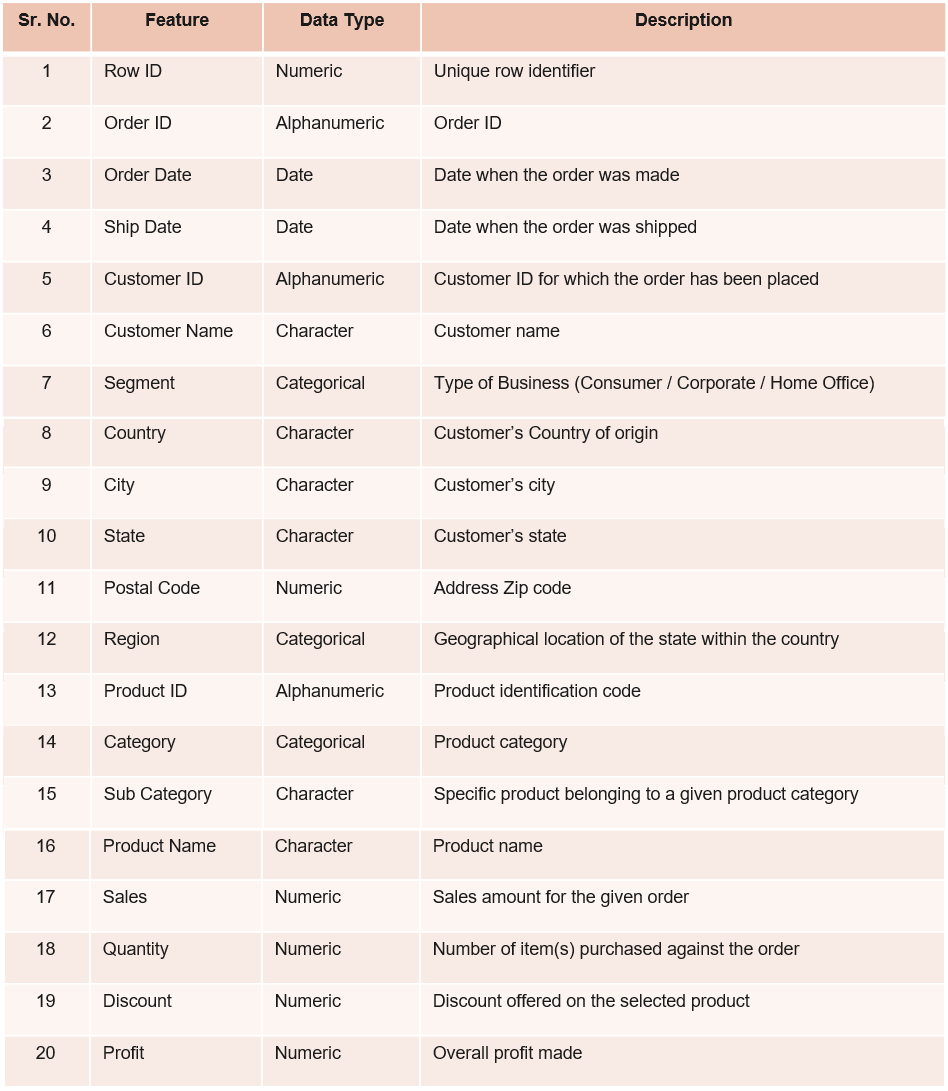

In [162]:
display.Image("./dd1.png")

## Import Modules

In [163]:
# import libraries
import pandas as pd                                              # to create data structures
import matplotlib.pyplot as plt                                  # for visualisation
import numpy as np                                               # for numerical operations
import warnings                                                  # to remove warnings
warnings.filterwarnings('ignore')                                # remove warnings
from statsmodels.tsa.stattools import acf,pacf,adfuller          # for stationarity check
from statsmodels.tsa.arima_model import ARIMA                    # for building model
from sklearn.metrics import mean_squared_error                   # for evaluation of model
import statsmodels.api as sm                                     # Ljung-Box test for model goodness
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf     # for visualisation ACF and PACF
from statsmodels.tsa.seasonal import seasonal_decompose          # for visualising seasonality and trend
from statsmodels.tsa.statespace.sarimax import SARIMAX           # for building model
from IPython import display                                      # for inserting picture

## Loading the dataset

In [164]:
# read the datasets
df = pd.read_excel("DS3_C6_S4_TimeSeries_Sales_Data_Project.xls") 

# previewing data
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Preprocessing the dataset

In [165]:
# for finding null values count
print('Count of null values of all the features is as follows :')
df.isnull().sum()

Count of null values of all the features is as follows :


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [166]:
# filtering data by cartegory furniture
df1 = df[df.Category=='Furniture']

# coverting order date column to datetime format
df1['Order Date'] =  pd.to_datetime(df1['Order Date'])

# sorting values according to order date
df1 = df1[['Order Date','Sales']].sort_values('Order Date').reset_index(drop=True)

# there are many sales for same day hence summing up sales for that day
df1 = df1.groupby('Order Date')['Sales'].sum().reset_index()

# setting index as order date
df1= df1.set_index('Order Date')

# previewing dataframe
df1.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


### Visualisation of data

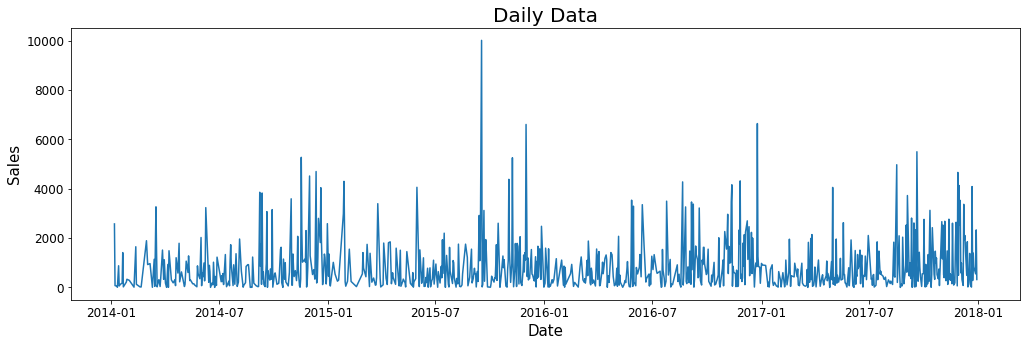

In [167]:
# Visualisation of data
fig,ax = plt.subplots(figsize=(17,5))
plt.plot(df1)
plt.title('Daily Data', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

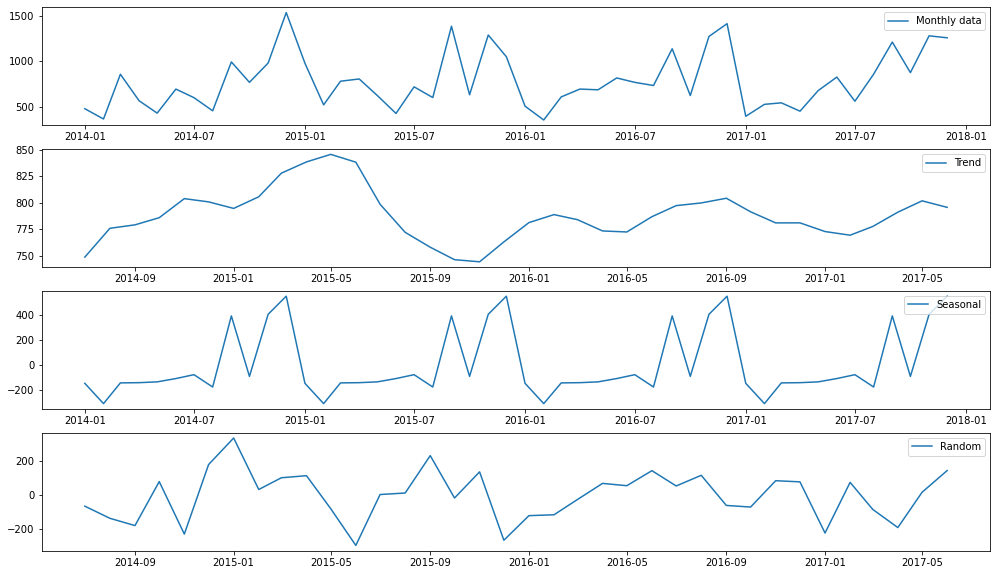

In [212]:
# resampling daily data to monthly data
df1=df1.resample('MS').mean()

# Time Series Components
# season_decompose breaks the data in components
decomp = seasonal_decompose(df1,period=12) 

d_trend = decomp.trend
d_seasonal = decomp.seasonal
d_residual = decomp.resid

# plot the components
fig,ax = plt.subplots(4,1,figsize=(17,10))

plt.subplot(411)
plt.plot(df1,label = 'Monthly data')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(d_residual,label='Random')
plt.legend(loc='upper right');

### Checking stationarity of data

In [169]:
# creating function to check stationarity of data
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    if pvalue <0.05:
        ret = 'Data is Stationary. Proceed to model building'
    else:
        ret = 'Data is not Stationary. Make it stationary'   
    return(ret)

# checking stationarity of data
checkStationarity(df1)

'Data is Stationary. Proceed to model building'

### Deciding p and q value

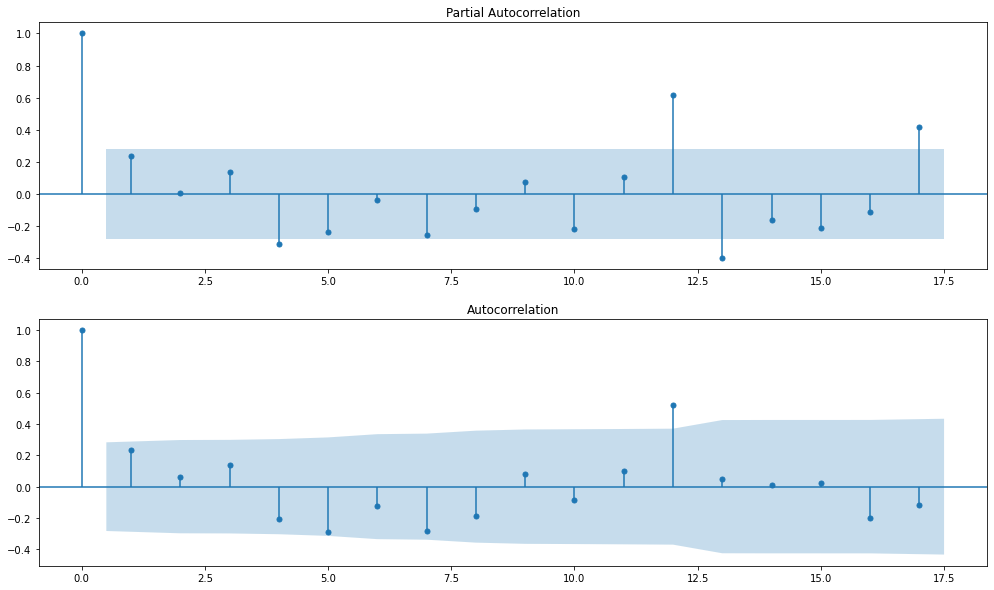

In [170]:
fig,ax = plt.subplots(2,1, figsize = (17,10))
plot_pacf(df1, ax=ax[0])
plot_acf(df1, ax=ax[1])
plt.show();

In [171]:
p = np.arange(4)
q = np.arange(2)
print('p values :',p,'\nq values :',q)

p values : [0 1 2 3] 
q values : [0 1]


### Spliting data into train and test

In [172]:
# split the data into train and test
rows = int(0.8*len(df1)) 

# while splitting always specify column name
train = df1.iloc[:rows]
test = df1.iloc[rows:]

print('Train={}, Test={}'.format(len(train), len(test)))

Train=38, Test=10


## Model Building

### Model 1 : ARMA Model

##### a. Building models with diffrent p and q values

In [173]:
# creating list of p and q value combinations 
lis=[]
for p in range(4):
    for q in range(2):
        lis.append((p,0,q))

# building model
model=[]
for i in lis:
    m = ARIMA(train, order=i).fit()
    model.append(m)

# checking model is good or not
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model


##### b. Prediction of values and evaluation of models 

In [174]:
# calculating AIC and BIC score   
aic=[]
bic=[]
for i in model:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast_1=[]
for i in model:
    fcast = i.predict(start=len(train), end=len(train)+len(test)-1)
    forecast_1.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast_1:
    mse = mean_squared_error(test, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(1,9):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis, 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 1,"(0, 0, 0)",546.451788,549.726960,91963.126344,303.254227
1,Model 2,"(0, 0, 1)",547.477279,552.390038,91153.547236,301.916457
2,Model 3,"(1, 0, 0)",547.582394,552.495152,90627.537647,301.044079
3,Model 4,"(1, 0, 1)",548.891200,555.441545,89270.982584,298.782500
4,Model 5,"(2, 0, 0)",549.494980,556.045325,91858.263970,303.081283
5,Model 6,"(2, 0, 1)",551.155907,559.343838,92380.688477,303.941916
6,Model 7,"(3, 0, 0)",551.059500,559.247431,94315.790719,307.108760
7,Model 8,"(3, 0, 1)",552.753322,562.578839,91585.877178,302.631587


##### c. Choosing model with lowest RMSE score

In [175]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
3,Model 4,"(1, 0, 1)",548.8912,555.441545,89270.982584,298.7825


##### d. Plotting forecasted vs actual values

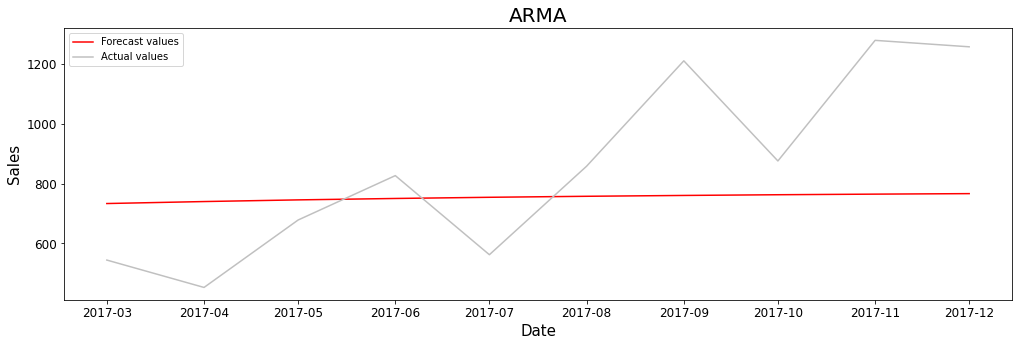

In [176]:
plt.figure(figsize=(17,5))
plt.plot(forecast_1[3],label= 'Forecast values', color='red')
plt.plot(test,label= 'Actual values', color='silver')
plt.title('ARMA', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

##### e. Summary of model

In [177]:
# Summary of model
model[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                     ARMA(1, 1)   Log Likelihood                -270.446
Method:                       css-mle   S.D. of innovations            292.672
Date:                Mon, 08 Aug 2022   AIC                            548.891
Time:                        09:25:42   BIC                            555.442
Sample:                    01-01-2014   HQIC                           551.222
                         - 02-01-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         775.4099     19.340     40.094      0.000     737.504     813.316
ar.L1.Sales     0.8430      0.121      6.990      0.000       0.607       1.079
ma.L1.Sales    -1.0000      0.071    -14.103      0.000      -1.139      -0.861
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1863           +0.0000j            1.1863            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### Model 2 : ARIMA Model

##### a. Building models with diffrent p and q values

In [178]:
# creating list of p and q value combinations 
lis=[]
for p in range(4):
    for q in range(2):
        lis.append((p,1,q))

# building model
models=[]
for i in lis:
    m = ARIMA(train, order=i).fit()
    models.append(m)

# checking model is good or not
c=1
for i in models:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model


##### b. Prediction of values and evaluation of models 

In [179]:
# calculating AIC and BIC score   
aic=[]
bic=[]
for i in models[1:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast_2=[]
for i in models[1:]:
    fcast = i.predict(start=len(train), end=len(train)+len(test)-1)
    forecast_2.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast_2:
    mse = mean_squared_error(test, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(2,9):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[1:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 2,"(0, 1, 1)",537.493275,542.326029,779769.596967,883.045637
1,Model 3,"(1, 1, 0)",547.160652,551.993406,816613.218528,903.666542
2,Model 4,"(1, 1, 1)",538.689838,545.133510,777736.805221,881.893874
3,Model 5,"(2, 1, 0)",543.765874,550.209546,796994.877986,892.745696
4,Model 6,"(2, 1, 1)",540.581351,548.635941,779741.887324,883.029947
5,Model 7,"(3, 1, 0)",545.716074,553.770663,797326.572084,892.931449
6,Model 8,"(3, 1, 1)",542.078061,551.743568,780617.541473,883.525631


##### c. Choosing model with lowest RMSE score

In [180]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]

Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
2,Model 4,"(1, 1, 1)",538.689838,545.13351,777736.805221,881.893874


##### d. Plotting forecasted vs actual values

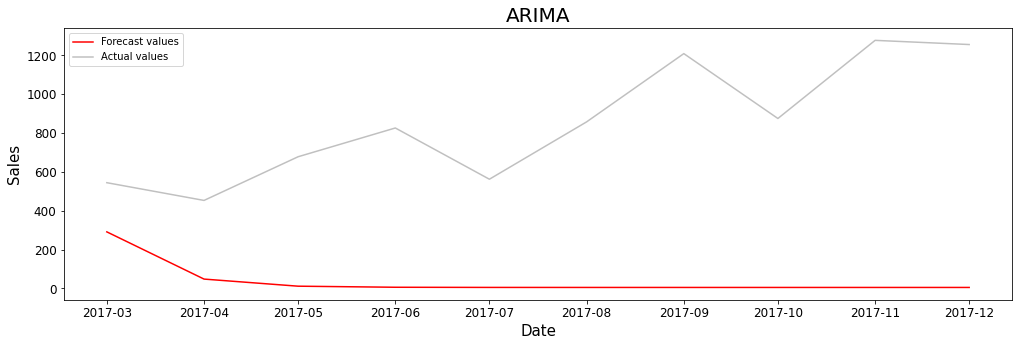

In [181]:
plt.figure(figsize=(17,5))
plt.plot(forecast_2[2],label= 'Forecast values', color='red')
plt.plot(test,label= 'Actual values', color='silver')
plt.title('ARIMA', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10)
plt.show();

##### e. Summary of model

In [182]:
models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   37
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -265.345
Method:                       css-mle   S.D. of innovations            301.075
Date:                Mon, 08 Aug 2022   AIC                            538.690
Time:                        09:25:43   BIC                            545.134
Sample:                    02-01-2014   HQIC                           540.962
                         - 02-01-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0679      5.172      0.980      0.327      -5.069      15.205
ar.L1.D.Sales     0.1504      0.168      0.896      0.370      -0.178       0.479
ma.L1.D.Sales    -1.0000      0.079    -12.686      0.000      -1.154      -0.846
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.6475           +0.0000j            6.6475            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### Model 3 : SARIMA Model

##### a. Building model

In [183]:
# building model with p=1, q=1
model_1 = SARIMAX(train, order=(1,0,1),seasonal_order=(1,0,1,12)).fit() 

# checking model is good or not
pvalue = sm.stats.acorr_ljungbox(model_1.resid, lags=[1], return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print('Not a good model')
else:
    print('Good model')

Good model


##### b Prediction of values, evaluation of model and plotting of actual vs predicted values

MSE : 27599.262776049418 
RMSE : 166.13025846018965


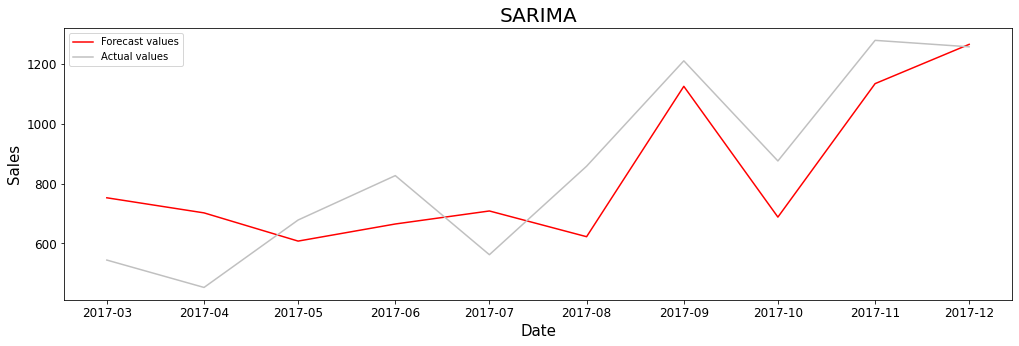

In [184]:
# forecasting values
forecast_3= model_1.predict(start=len(train), end=len(train)+len(test)-1)

# evaluation of model
mse = mean_squared_error(test, forecast_3)
rmse = np.sqrt(mse)
print('MSE :',mse,'\nRMSE :',rmse)

# plotting actual vs forecasted values
plt.figure(figsize=(17,5))
plt.plot(forecast_3,label= 'Forecast values', color='red')
plt.plot(test,label= 'Actual values', color='silver')
plt.title('SARIMA', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10);

#### Forecasting next 12 months values

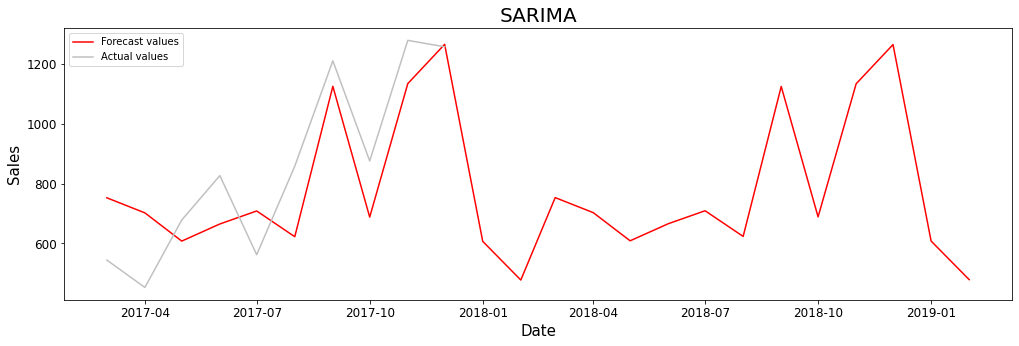

In [185]:
# forecasting values for next 12 months
fcast= model_1.forecast(24)

# plotting actual vs forecasted values
plt.figure(figsize=(17,5))
plt.plot(fcast,label= 'Forecast values', color='red')
plt.plot(test,label= 'Actual values', color='silver')
plt.title('SARIMA', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10);

#### Summary of model

In [186]:
#### Summary of model
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   38
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -264.132
Date:                            Mon, 08 Aug 2022   AIC                            538.265
Time:                                    09:25:44   BIC                            546.453
Sample:                                01-01-2014   HQIC                           541.178
                                     - 02-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9985      0.030     33.512      0.000       0.940       1.057
ma.L1         -0.9845      0.265     -3.720      0.000      -1.503      -0.466
ar.S.L12       0.9973      0.022     45.735      0.000       0.955       1.040
ma.S.L12      -0.8914      0.447     -1.995      0.046      -1.767      -0.016
sigma2      3.242e+04   1.57e-05   2.06e+09      0.000    3.24e+04    3.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.47   Prob(JB):                         0.86
Heteroskedasticity (H):               0.50   Skew:                             0.20
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+24. Standard errors may be unstable.
"""

### Model 4 : SARIMAX Model

##### a. Data Preparation  

In [220]:
# Copying original dataframe
df_all = df.copy()

# filtering data by cartegory furniture
df_all = df_all[df_all.Category=='Furniture']

# coverting order date column to datetime format
df_all['Order Date'] =  pd.to_datetime(df_all['Order Date'])

# sorting values according to order date
df_all = df_all.sort_values('Order Date').reset_index(drop=True)

# there are many sales for same day hence summing up sales for that day
df_all = df_all.groupby('Order Date')['Sales','Quantity','Discount'].sum().reset_index()

# setting index as order date
df_all= df_all.set_index('Order Date')

# previewing dataframe
df_all.head()

,Sales,Quantity,Discount
Order Date,,,
2014-01-06,2573.820,9,0.00
2014-01-07,76.728,3,0.60
2014-01-10,51.940,1,0.00
2014-01-11,9.940,2,0.00
2014-01-13,879.939,9,0.15


In [221]:
# resampling daily data to monthly data
df_all=df_all.resample('MS').mean()

# split the data into train and test
rows = int(0.8*len(df_all)) 

train_all = df_all.iloc[:rows]
test_all = df_all.iloc[rows:]

# while splitting always specify column name
exog_train = train_all[['Quantity','Discount']]
exog_test = test_all[['Quantity','Discount']]

print('Train={}, Test={}'.format(len(exog_train), len(exog_test)))

Train=38, Test=10


##### b. Model Building

In [222]:
# building model with p=1, q=1
model_2 = SARIMAX(train_all.Sales, order=(1,0,1),seasonal_order=(1,0,1,12),exog=exog_train.values).fit() 

# checking model is good or not
pvalue = sm.stats.acorr_ljungbox(model_2.resid, lags=[1], return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print('Not a good model')
else:
    print('Good model')

Good model


##### c. Prediction of values and evaluation of model

In [223]:
# forecasting values
forecast_4= model_2.forecast(len(test_all.Sales), exog=exog_test.values)

# evaluation of model
mse = mean_squared_error(test_all.Sales, forecast_4)
rmse = np.sqrt(mse)
print('MSE :',mse,'\nRMSE :',rmse)

MSE : 31509.981467429352 
RMSE : 177.5105108646509


##### d. Plotting Actual vs predicted values 

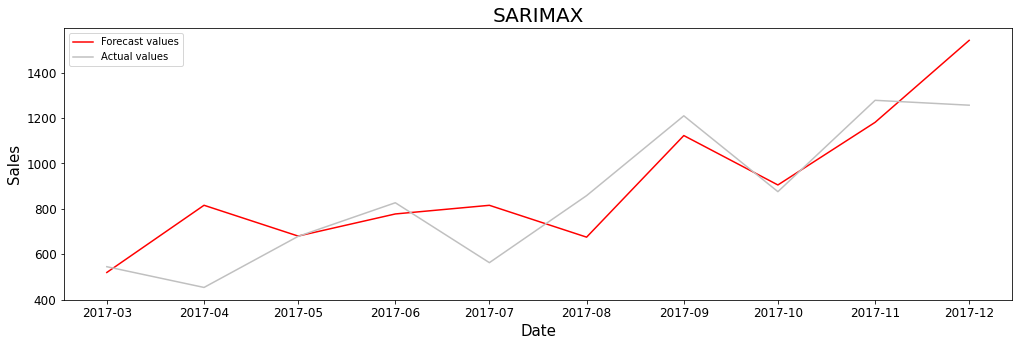

In [224]:
plt.figure(figsize=(17,5))
plt.plot(forecast,label= 'Forecast values', color='red')
plt.plot(test.Sales,label= 'Actual values', color='silver')
plt.title('SARIMAX', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10);

### Final Wordings

In [225]:
round(pd.DataFrame({'Models':['ARMA','ARIMA','SARIMA', 'SARIMAX'], 
              'MSE':[mean_squared_error(test, forecast_1[3]), mean_squared_error(test, forecast_2[2]),
                    mean_squared_error(test, forecast_3), mean_squared_error(test_all.Sales, forecast_4)],
            'RMSE':[np.sqrt(mean_squared_error(test, forecast_1[3])), np.sqrt(mean_squared_error(test, forecast_2[2])),
                np.sqrt(mean_squared_error(test, forecast_3)), np.sqrt(mean_squared_error(test_all.Sales, forecast_4))],
             'AIC':[model[3].aic, models[3].aic, model_1.aic, model_2.aic], 
              'BIC':[model[3].bic, models[3].bic, model_1.bic, model_2.bic]}),2)

,Models,MSE,RMSE,AIC,BIC
0,ARMA,89270.98,298.78,548.89,555.44
1,ARIMA,777736.81,881.89,538.69,545.13
2,SARIMA,27599.26,166.13,538.26,546.45
3,SARIMAX,31509.98,177.51,492.23,503.70


#### CONCLUSION :
SARIMA is the best model to predict sales of furniture with lowest RMSE value i.e. 166.13 than any other models